## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset

# Adapt this import to your specific directory tree.
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
input_data = torch.from_numpy(np.load("input.npy")).type(torch.float32)
input_mu = torch.from_numpy(np.load("input_mu.npy")).type(torch.float32)
output_data = torch.from_numpy(np.load("output.npy")).type(torch.float32)
print(input_data.shape)
print(input_mu.shape)
print(output_data.shape)



torch.Size([64, 100, 100, 3])
torch.Size([64, 2])
torch.Size([64, 100, 100])


In [4]:
total_input = []
for i in range (input_data.shape[0]):
    for j in range (input_data.shape[1]):
        for k in range (input_data.shape[1]):
            total_input.append(np.append(input_data[i][j][k][:-1].flatten().numpy(), input_mu[i].flatten().numpy() ))
print(total_input[0])
print(total_input[0].shape)
print(type(total_input[0]))

[-1.         -1.         -0.09366927 -0.0783205 ]
(4,)
<class 'numpy.ndarray'>


In [5]:
total_input = np.vstack(total_input)
print(type(total_input))
# 

<class 'numpy.ndarray'>


In [6]:
total_input = torch.from_numpy(total_input)


In [7]:
print((total_input[0]))

total_output = torch.flatten(output_data)
print(total_output[0])
print(total_output.shape)
print(total_input.shape)

tensor([-1.0000, -1.0000, -0.0937, -0.0783])
tensor(1.8514e-20)
torch.Size([640000])
torch.Size([640000, 4])


In [8]:
ip_shape = 4
op_shape = 1
model = NeuralNet(input_dimension=ip_shape,
                            output_dimension=op_shape,
                            n_hidden_layers=4,
                            neurons=20,
                            regularization_param=0.,
                            regularization_exp=2.,
                            retrain_seed=42)

model = model.to(device)

In [9]:
optimizer_ADAM = optim.Adam(model.parameters(),
                            lr=float(0.005))

ratio_train = 0.8                            
n_train = int(np.round(len(total_input) * ratio_train))

train_input = total_input[:n_train].to(device)
train_output = total_output[:n_train].to(device)
test_input = total_input[n_train:].to(device)
test_output = total_output[n_train:].to(device)

batch_size = 16

training_set = DataLoader(TensorDataset(train_input, train_output), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(test_input, test_output), batch_size=batch_size, shuffle=False)



print(train_input.shape)
print(train_output.shape)
print(test_output.shape)
print(test_input.shape)

torch.Size([512000, 4])
torch.Size([512000])
torch.Size([128000])
torch.Size([128000, 4])


In [10]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p) + model.regularization()
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history
epochs = 1
hist = fit(model= model, training_set=training_set, num_epochs=epochs, optimizer=optimizer_ADAM, p=2, verbose=True)

################################  0  ################################
Loss:  0.0013301311565468723


## Evaluate


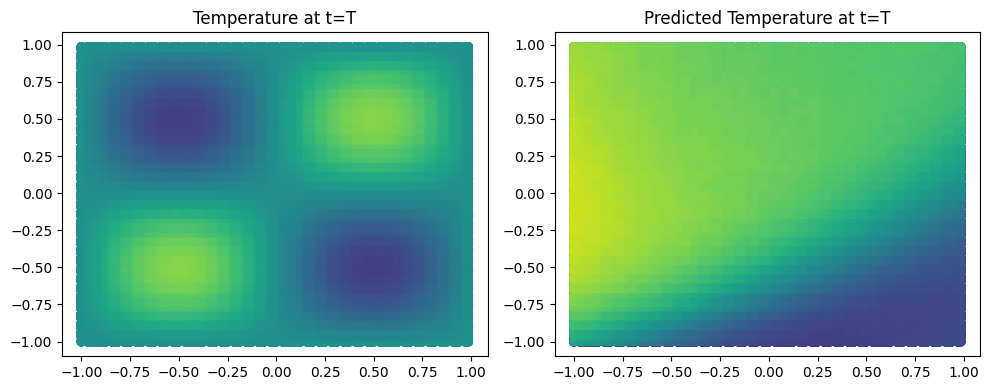

<Figure size 640x480 with 0 Axes>

In [41]:
test_input = test_input.to(device)
model = model.to(device)
test_output = test_output.to(device=device)
with torch.no_grad():
    op_pred = model(test_input).detach().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a figure with two subplots
    # print(test_input[:, 0].shape)
    # print(test_input[:, 1].shape)
    # print(test_output.shape)
    axes[0].scatter(test_input[:, 0], test_input[:,1], c=test_output)
    axes[0].set_title('Temperature at t=T')

    axes[1].scatter(test_input[:,0], test_input[:,1], c=op_pred)
    axes[1].set_title('Predicted Temperature at t=T')

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()  # Display the plot
    plt.savefig('Results/Param/epoch1.png')